### В данной домашней работе Вам предстоит отработать следующие 2 навыка: работа с пропущенными значениями и анализ выбросов.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error

data = pd.read_csv('processed_data_with_new_features.csv', index_col='id')

In [2]:
data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
id,,,,,,,,,,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
id2377394,0,930.399753,0,1.807119,6.498282,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id3858529,1,NaN,0,6.392080,7.661527,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
id3504673,1,NaN,0,1.487155,6.063785,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
id2181028,1,930.399753,0,1.189925,6.077642,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Никудышный гном случайно пролил кофе на папку с данными и кодом. К несчастью, из-за этого они с братьями потеряли кучу информации в столбиках **passenger_count** и **distance_km**.

In [9]:
### Выведите количество пропусков в данных колонках
### На всякий случай, проверьте целостность данных в остальных

for column in data.columns:
    print(column, ': ' ,data[column].isna().sum())

vendor_id :  0
passenger_count :  145864
store_and_fwd_flag :  0
distance_km :  145864
log_trip_duration :  0
anomaly :  0
traffic_jam :  0
day_of_week_1 :  0
day_of_week_2 :  0
day_of_week_3 :  0
day_of_week_4 :  0
day_of_week_5 :  0
day_of_week_6 :  0
hour_1 :  0
hour_2 :  0
hour_3 :  0
hour_4 :  0
hour_5 :  0
hour_6 :  0
hour_7 :  0
hour_8 :  0
hour_9 :  0
hour_10 :  0
hour_11 :  0
hour_12 :  0
hour_13 :  0
hour_14 :  0
hour_15 :  0
hour_16 :  0
hour_17 :  0
hour_18 :  0
hour_19 :  0
hour_20 :  0
hour_21 :  0
hour_22 :  0
hour_23 :  0
month_2 :  0
month_3 :  0
month_4 :  0
month_5 :  0
month_6 :  0


In [35]:
data.isna().sum()

vendor_id                  0
passenger_count       145864
store_and_fwd_flag         0
distance_km           145864
log_trip_duration          0
anomaly                    0
traffic_jam                0
day_of_week_1              0
day_of_week_2              0
day_of_week_3              0
day_of_week_4              0
day_of_week_5              0
day_of_week_6              0
hour_1                     0
hour_2                     0
hour_3                     0
hour_4                     0
hour_5                     0
hour_6                     0
hour_7                     0
hour_8                     0
hour_9                     0
hour_10                    0
hour_11                    0
hour_12                    0
hour_13                    0
hour_14                    0
hour_15                    0
hour_16                    0
hour_17                    0
hour_18                    0
hour_19                    0
hour_20                    0
hour_21                    0
hour_22       

Начнем с **passenger_count**. Вообще говоря, изначально это была категориальная колонка, к которой мы применили технику OneHotEncoder. Чтобы избавиться от пропусков в данных, конечно, можно просто убрать все объекты, в которых есть пропуски, но тогда мы потеряем ценную информацию. 

Воспользуйтесь относительно простым приемом из лекции: в указанной колонке заполните пропуски самым *популярным* значением среди неотсутствующих.

In [40]:
### Your code is here
passenger_count_most_common = data.passenger_count.value_counts().reset_index()['passenger_count'].values[0]
print((passenger_count_most_common))

930.3997532751514


In [28]:
data.shape

(1458644, 41)

In [41]:
data['passenger_count'] = data['passenger_count'].fillna(passenger_count_most_common)

С колонкой **distance_km** поступим более интересным способом!

Чтобы заполнить пропуск в данной колонке для того или иного объекта, можно находить наиболее похожий на него объект и подглядывать в его значение **distance_km**. Для того, чтобы понять, насколько объекты похожи друг на друга, необходимо использовать Евклидово расстояние между этими самыми объектами в пространстве всех признаков!

С учетом количества объектов в нашем датасете и признаков, посчитать попарные расстояния будет мега-сложно. Поэтому давайте называть объекты похожими, если они принадлежат одной категории, составленной из следующих колонок:

1. vendor_id
2. store_and_fwd_flag
3. traffic_jam
4. month_2
5. month_3
6. month_4
7. month_5
8. month_6

Внутри каждой группы найдите среднее значение признака **distance_km** и заполните NaN'ы в объектах с пропуском в соответствии с тем, к какой категории относится данный объект. Похожее упражнение мы делали на практике в занятии!

**Hint**: достаточно просто взять group by по указанным выше категориальным колонкам и верно вставить полученный результат в исходную табличку.

P.S. Колонки выбраны случайным образом. Можно было взять и другую комбинацию.

In [42]:
### Your code is here
data.groupby(['vendor_id', 'store_and_fwd_flag', 'traffic_jam', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6'])['distance_km'].transform('mean')

id
id2875421    3.466395
id2377394    3.463570
id3858529    3.183494
id3504673    3.468311
id2181028    3.466395
               ...   
id2376096    3.468311
id1049543    3.323767
id2304944    3.468311
id2714485    3.323767
id1209952    3.389926
Name: distance_km, Length: 1458644, dtype: float64

In [44]:
### Убедимся, что пропусков не осталось

### Your code is here

data['distance_km'] = data['distance_km'].fillna(data.groupby(['vendor_id', 'store_and_fwd_flag', 'traffic_jam', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6'])['distance_km'].transform('mean'))


In [45]:
data.isna().sum()

vendor_id             0
passenger_count       0
store_and_fwd_flag    0
distance_km           0
log_trip_duration     0
anomaly               0
traffic_jam           0
day_of_week_1         0
day_of_week_2         0
day_of_week_3         0
day_of_week_4         0
day_of_week_5         0
day_of_week_6         0
hour_1                0
hour_2                0
hour_3                0
hour_4                0
hour_5                0
hour_6                0
hour_7                0
hour_8                0
hour_9                0
hour_10               0
hour_11               0
hour_12               0
hour_13               0
hour_14               0
hour_15               0
hour_16               0
hour_17               0
hour_18               0
hour_19               0
hour_20               0
hour_21               0
hour_22               0
hour_23               0
month_2               0
month_3               0
month_4               0
month_5               0
month_6               0
dtype: int64

In [46]:
data.head(20).to_csv('step_7.csv', sep=';', index=False)

### Теперь наши данные чисты! Замерьте качество модели на Кросс-Валидации

In [47]:
from sklearn.model_selection import KFold

selector = KFold(n_splits=4, shuffle=True, random_state=33)

from sklearn.model_selection import cross_validate
X = data.drop(columns=['log_trip_duration'])
y = data.log_trip_duration

mse_list = []
### Your code is here
for train_index, test_index in selector.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)

    mse_list.append(mean_squared_error(y_test, model.predict(X_test)))

cross_val_error = np.mean(mse_list)
print(f"MSLE на Кросс-валидации: {round(cross_val_error, 3)}")

MSLE на Кросс-валидации: 0.431


### Проведем анализ выбросов! Нарисуйте ящик с усами и гистограмму для таргетной переменной.

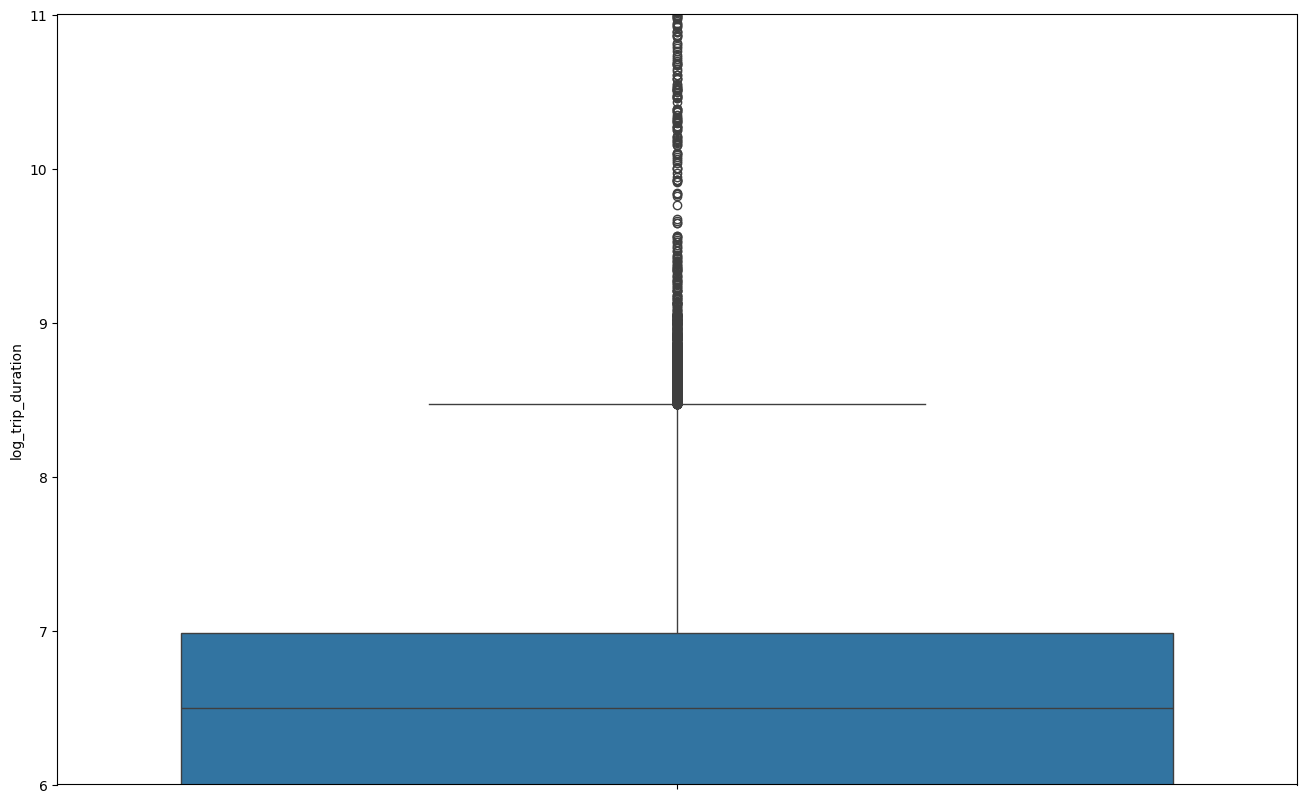

In [51]:
### Your code is here
import seaborn as sns

fig = plt.figure()
fig.set_size_inches(16, 10)
sns.boxplot(data=data.log_trip_duration)
plt.ylim(6, 11)

plt.show()


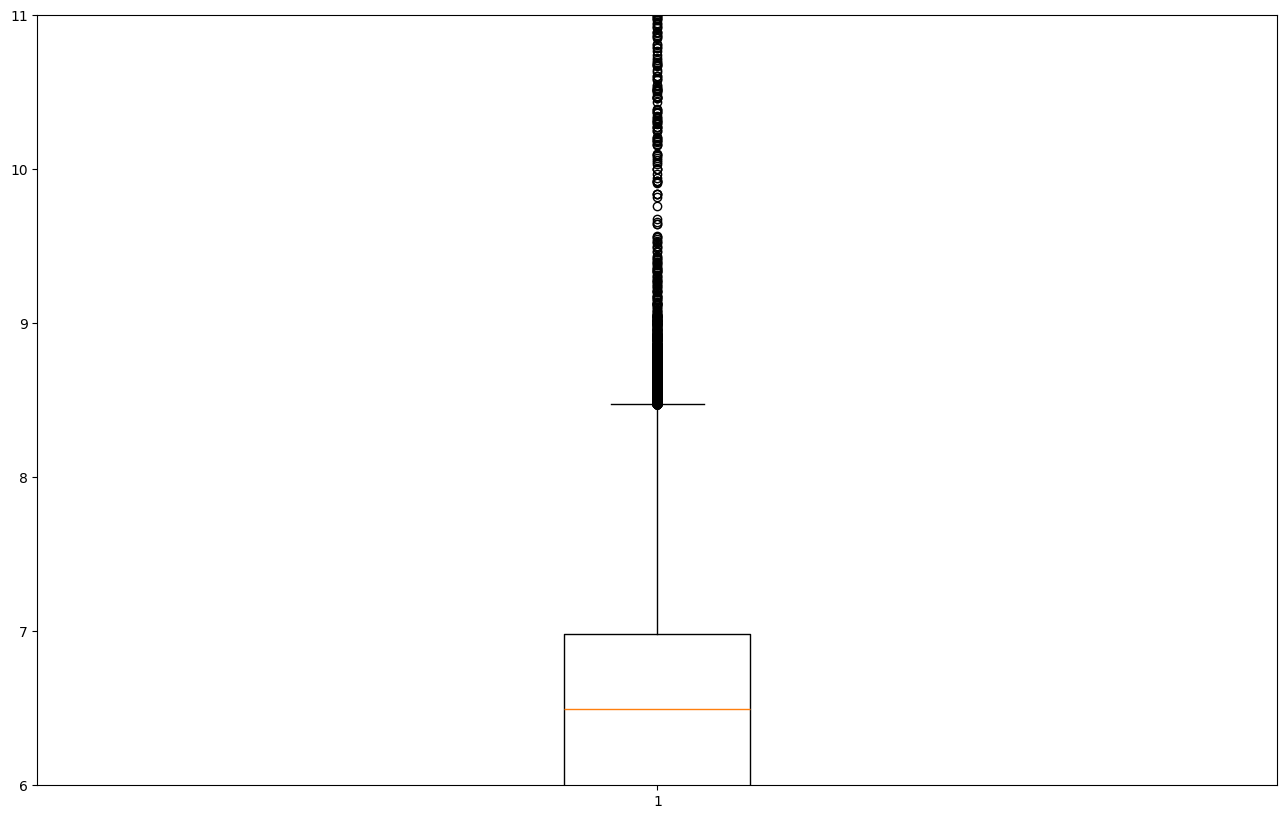

In [65]:
fig = plt.figure()
fig.set_size_inches(16, 10)
plt.boxplot(data.log_trip_duration.values)
plt.ylim(6, 11)

plt.show()


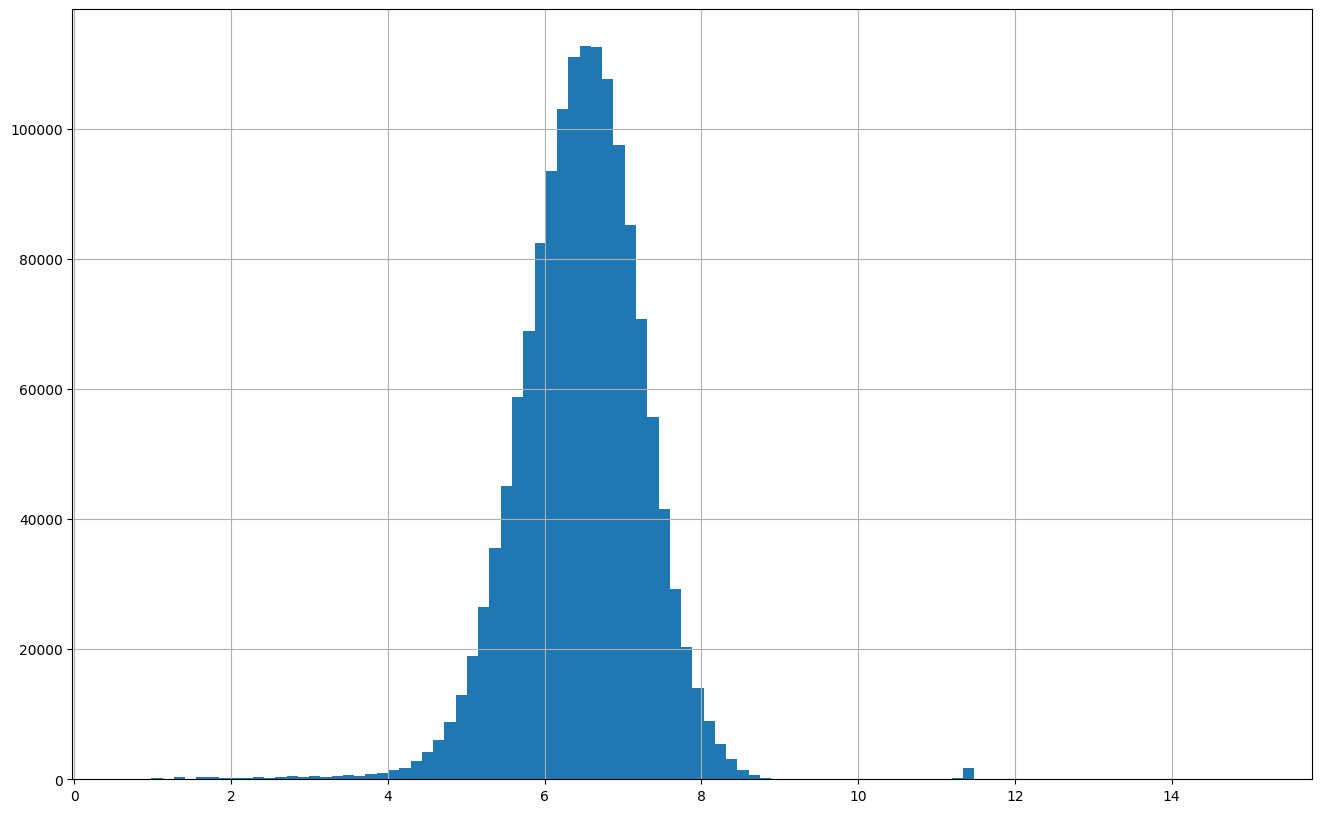

In [67]:
fig = plt.figure()
fig.set_size_inches(16, 10)
data.log_trip_duration.hist(bins=100)
# plt.ylim(6, 11)

plt.show()


Есть ли, на ваш взгляд, в данных выбросы?

Кажется, что да!

Давайте почистим их, удалив те объекты, таргеты которых находятся вне промежутка

(топ 99,5% значение;   топ 0,5% значение)

In [68]:
### Your code is here
min_threshold = data.log_trip_duration.quantile(0.005)
max_threshold = data.log_trip_duration.quantile(0.995)

Снова замерьте качество на кросс-валидации, используя старый selector

In [69]:
### Your code is here
filtered_data = data[(data.log_trip_duration > min_threshold) & (data.log_trip_duration < max_threshold)]


In [70]:
X = filtered_data.drop(columns=['log_trip_duration'])
y = filtered_data.log_trip_duration

mse_list = []
### Your code is here
for train_index, test_index in selector.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)

    mse_list.append(mean_squared_error(y_test, model.predict(X_test)))

cross_val_error = np.mean(mse_list)
print(f"MSLE на Кросс-валидации: {round(cross_val_error, 3)}")

MSLE на Кросс-валидации: 0.35
